# Red con Style Transfer para creación de un Avatar a partir de una foto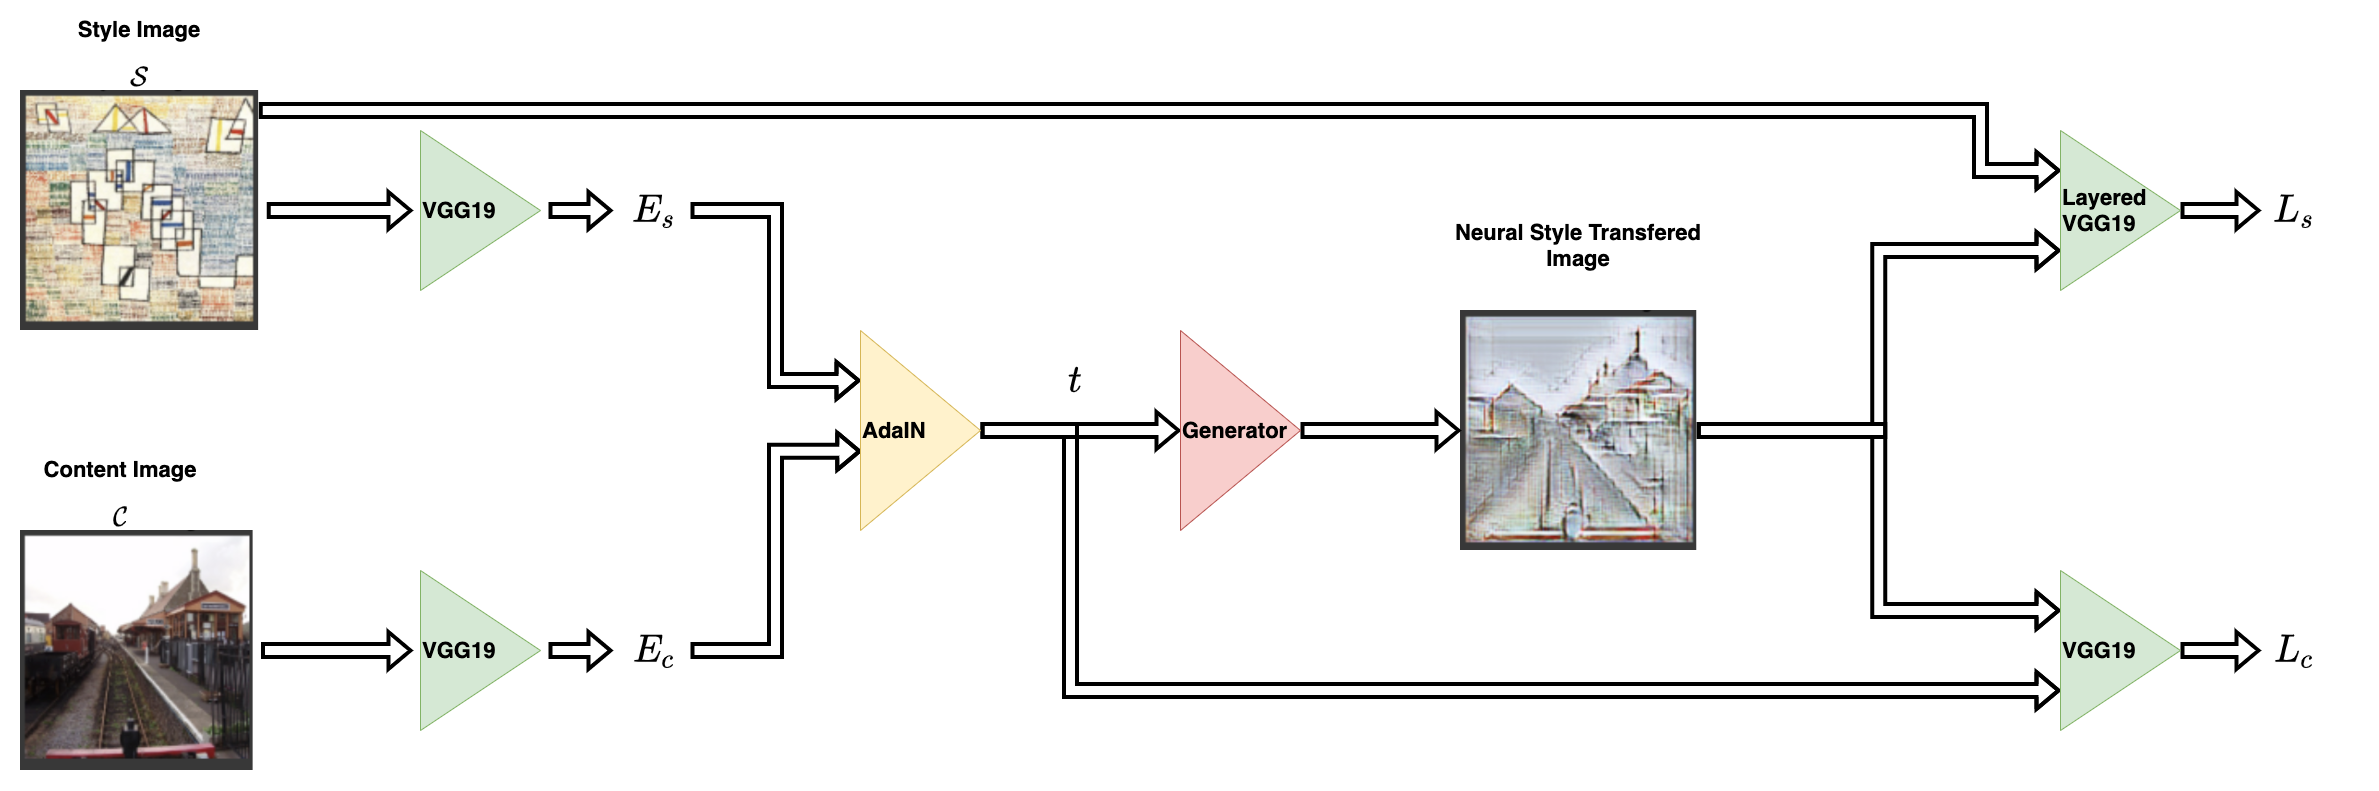

# Datasets

## Descarga de datasets

In [4]:
%cd ..
%cd ..

/kaggle
/


In [5]:
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

--2024-05-16 14:01:13--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.88, 52.219.194.24, 52.219.117.144, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: 'celeba.zip'

celeba.zip          100%[===================>]   1.34G  49.0MB/s    in 28s     

2024-05-16 14:01:41 (49.8 MB/s) - 'celeba.zip' saved [1443490838/1443490838]



In [6]:
%mv /kaggle/input/cartoonset10k/cartoonset10k.tgz /

mv: cannot remove '/kaggle/input/cartoonset10k/cartoonset10k.tgz': Read-only file system


In [ ]:
!tar -xvzf cartoonset10k.tgz
!unzip celeba.zip
#Creación del dataset
%mkdir dataset
%cd dataset
%mkdir celeba10k
%mkdir cartoonset10k
%cd ..

Pasamos solo los archivos png a cartoonset10k

In [8]:
%cd cartoonset10k/
%cp *.png ../dataset/cartoonset10k/
%cd ..

/cartoonset10k
/


Pasamos sólo 10,000 imagenes de CelebA

In [9]:
%cd img_align_celeba/
%cp {000001..010000}.jpg ../dataset/celeba10k/
%cd ..

/img_align_celeba
/


Cantidad de imagenes en el dataset

In [10]:
!ls dataset/celeba10k/ | wc -l
!ls dataset/cartoonset10k/ | wc -l

10000
10000


## Creación de los dataset

In [11]:
import tensorflow as tf
import os
AUTOTUNE   = tf.data.AUTOTUNE #Para usar la cantidad optima de hilos del CPU
IMAGE_SIZE = (80,80)

2024-05-16 14:02:37.110430: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 14:02:37.110533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 14:02:37.287476: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
def decode_and_resize(image_path):

  ''' Decodificamos las imagenes'''
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, dtype="float32")
  image = tf.image.resize(image, IMAGE_SIZE)
  return image

Creamos listas con las rutas de las imagenes

In [16]:
ruta_style       = '/dataset/cartoonset10k'
ruta_content     = '/dataset/celeba10k'
archivos_style   = os.listdir(ruta_style)
archivos_content = os.listdir(ruta_content)
style   = [os.path.join(ruta_style, path) for path in archivos_style]
content = [os.path.join(ruta_content, path) for path in archivos_content]

In [17]:
def separador(lista):
  ''' train 80%
      val   10%
      test  10%'''
  total = len(lista)
  train = lista[: int(0.8 * total)]
  val = lista[int(0.8 * total) : int(0.9 * total)]
  test = lista[int(0.9 * total) :]
  return train, val, test

In [18]:
train_style, val_style, test_style = separador(style)
train_content, val_content, test_content = separador(content)

In [19]:
train_content[0]

'/dataset/celeba10k/007669.jpg'

In [20]:
def dataset(data):
  ds = (
      tf.data.Dataset.from_tensor_slices(data)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE).repeat()
  )
  return ds

Creamos los datasets

In [21]:
train_style_ds   = dataset(train_style)
val_style_ds     = dataset(val_style)
test_style_ds    = dataset(test_style)
train_content_ds = dataset(train_content)
val_content_ds   = dataset(val_content)
test_content_ds  = dataset(test_content)

In [22]:
BATCH_SIZE=128

In [24]:
def union_dataset(style_dataset, content_dataset, BATCH_SIZE=32):
  '''Une las imagenes style y content'''
  ds = (
      tf.data.Dataset.zip(style_dataset, content_dataset)
      .shuffle(BATCH_SIZE * 2)
      .batch(BATCH_SIZE)
      .prefetch(AUTOTUNE)
  )
  return ds

In [25]:
train_ds = union_dataset(train_style_ds, train_content_ds)
val_ds = union_dataset(val_style_ds, val_content_ds)
test_ds = union_dataset(test_style_ds, test_content_ds)

# Creación del modelo

In [26]:
import numpy as np
from tensorflow import keras
import tensorflow_datasets as tfds
from keras import layers

In [27]:
from keras.applications.vgg19 import VGG19
from keras.models import Model

## Funciones a usar

In [28]:
def get_encoder():
  '''Nos regresa la salida de la capa block4_conv1
      Es el contenido'''
  vgg19 = VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(*IMAGE_SIZE, 3),
  )
  vgg19.trainable = False
  mini_vgg19 = Model(vgg19.input, vgg19.get_layer("block4_conv1").output)
  inputs = layers.Input([*IMAGE_SIZE, 3])
  mini_vgg19_out = mini_vgg19(inputs)
  return Model(inputs, mini_vgg19_out, name="mini_vgg19")

In [29]:
def get_mean_std(x, epsilon=1e-5):
  '''Nos regresa el promedio y la desviación estandar de un tensor'''
  axes = [1, 2]
  mean, variance = tf.nn.moments(x, axes=axes, keepdims=True)
  standard_deviation = tf.sqrt(variance + epsilon)
  return mean, standard_deviation

Variables
$$ y ≡ style$$
$$ x ≡ content$$
$$ \sigma ≡ std$$
$$ \mu \equiv mean$$


$$AdaIn(x,y) = \sigma(y)(\frac{x-\mu(x)}{\sigma(x)}) + \mu(y)$$

In [30]:
def ada_in(style, content):
  '''Calcula el AdaIn'''
  content_mean, content_std = get_mean_std(content)
  style_mean, style_std = get_mean_std(style)
  t = style_std * (content - content_mean) / content_std + style_mean
  return t

In [31]:
def get_decoder():
  '''El decoder es similar al modelo VGG19 pero al reves'''
  config = {"kernel_size": 3, "strides": 1, "padding": "same", "activation": "relu"}
  decoder = keras.Sequential(
      [
          layers.InputLayer((None, None, 512)),
          layers.Conv2D(filters=512, **config),
          layers.UpSampling2D(),
          layers.Conv2D(filters=256, **config),
          layers.Conv2D(filters=256, **config),
          layers.Conv2D(filters=256, **config),
          layers.Conv2D(filters=256, **config),
          layers.UpSampling2D(),
          layers.Conv2D(filters=128, **config),
          layers.Conv2D(filters=128, **config),
          layers.UpSampling2D(),
          layers.Conv2D(filters=64, **config),
          layers.Conv2D(
              filters=3,
              kernel_size=3,
              strides=1,
              padding="same",
              activation="sigmoid",
          ),
      ]
  )
  return decoder

In [32]:
def get_loss_net():
  '''Nos regresa los valores de los estilos
    de cada bloque y el ultimo
    es el contenido de la imagen reconstruida'''
  vgg19 = VGG19(
      include_top=False, weights="imagenet", input_shape=(*IMAGE_SIZE, 3)
  )
  vgg19.trainable = False
  layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]
  '''VGG19 tiene cinco bloques con distintas convolucionales, en este caso solo
      agarramos las primeras de cada bloque'''
  outputs = [vgg19.get_layer(name).output for name in layer_names]
  mini_vgg19 = Model(vgg19.input, outputs)
  inputs = layers.Input([*IMAGE_SIZE, 3])
  mini_vgg19_out = mini_vgg19(inputs)
  return Model(inputs, mini_vgg19_out, name="loss_net")

## Contrucción del modelo

In [33]:
class NeuralStyleTransfer(tf.keras.Model):
    def __init__(self, encoder, decoder, loss_net, style_weight, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_net = loss_net
        self.style_weight = style_weight

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.style_loss_tracker = keras.metrics.Mean(name="style_loss")
        self.content_loss_tracker = keras.metrics.Mean(name="content_loss")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, inputs):
        style, content = inputs

        # Inicializamos las funciones de costo
        loss_content = 0.0
        loss_style = 0.0

        with tf.GradientTape() as tape:
            # Obtenemos solo la capa block_conv4 que es el contenido de ambas imagenes
            style_encoded = self.encoder(style)
            content_encoded = self.encoder(content)

            # Calculamos el AdaIN
            t = ada_in(style=style_encoded, content=content_encoded)

            # Partiendo del AdaIN empezamos a entrenar el decoder
            reconstructed_image = self.decoder(t)

            # Calculamos la función de costo

            #Obtenemos los estilos de la imagen reconstruida y su contenido
            reconstructed_vgg_features = self.loss_net(reconstructed_image)
            #Obtenemos los estilos de la imagen de estilo y su contenido
            style_vgg_features = self.loss_net(style)
            #loss_fn es la función de error MeanSquaredError
            #Calculamos la función de costo entre t y el contendio de la imagen reconstruida
            loss_content = self.loss_fn(t, reconstructed_vgg_features[-1])


            for inp, out in zip(style_vgg_features, reconstructed_vgg_features):
                mean_inp, std_inp = get_mean_std(inp)
                mean_out, std_out = get_mean_std(out)

                loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(std_inp, std_out)

                #Calculamos el MeanSquareError entre las medias y std de los estilos de
                #la image de estilo y la imagen reconstruida

            loss_style = self.style_weight * loss_style   #La multiplicamos por un peso
            total_loss = loss_content + loss_style        #Sumamos todas las funciones de costo

        # Calculamos los gradientes y optimizamos el decoder

        trainable_vars = self.decoder.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Actualizamos los trakers
        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(loss_content)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    def test_step(self, inputs):
        style, content = inputs

        # Inicializamos las funciones de costo
        loss_content = 0.0
        loss_style = 0.0

        # Obtenemos solo la capa block_conv4 que es el contenido de ambas imagenes
        style_encoded = self.encoder(style)
        content_encoded = self.encoder(content)

        # Calculamos el AdaIN
        t = ada_in(style=style_encoded, content=content_encoded)

        # Partiendo del AdaIN reconstruimos la imagen
        reconstructed_image = self.decoder(t)

        # Calculamos la funcion de costo
        recons_vgg_features = self.loss_net(reconstructed_image)
        style_vgg_features = self.loss_net(style)
        loss_content = self.loss_fn(t, recons_vgg_features[-1])
        for inp, out in zip(style_vgg_features, recons_vgg_features):
            mean_inp, std_inp = get_mean_std(inp)
            mean_out, std_out = get_mean_std(out)
            loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(
                std_inp, std_out
            )
        loss_style = self.style_weight * loss_style
        total_loss = loss_content + loss_style

        # Actualizamos los trackers
        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(loss_content)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    @property
    def metrics(self):
        return [
            self.style_loss_tracker,
            self.content_loss_tracker,
            self.total_loss_tracker,
        ]

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'encoder': self.encoder,
            'decoder': self.decoder,
            'loss_net': self.loss_net,
            'style_weight': self.style_weight,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# Entrenamiento del modelo

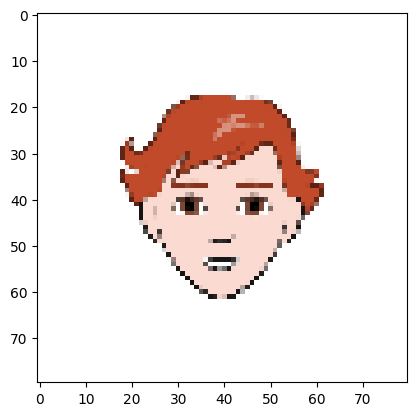

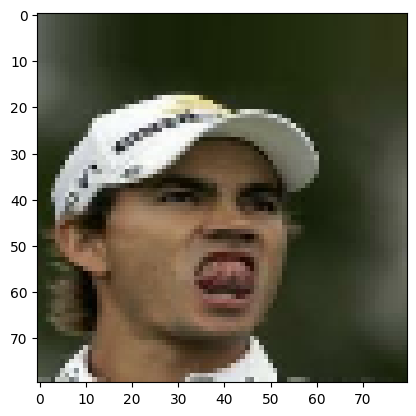

In [34]:
import matplotlib.pyplot as plt
test_style, test_content = next(iter(test_ds.skip(4)))
plt.imshow(test_style[0])
plt.show()
plt.imshow(test_content[0])
plt.show()

In [35]:
%cd
%cd ..

/root
/


Cargamos el enconder que ya hemos entrenado

In [36]:
import tensorflow as tf
from keras.models import load_model
# Cargar el modelo
decoderReducido =load_model('/kaggle/input/decoder_reducidov1/tensorflow2/decoder_variationv1/2/decoderReducidoV2_1.h5')

# Entrenamos el modelo

In [92]:
optimizer = keras.optimizers.Adam(learning_rate=0.8e-4)
loss_fn = keras.losses.MeanSquaredError()

encoder = get_encoder()
loss_net = get_loss_net()
style_weight=0.75
model = NeuralStyleTransfer(
    encoder=encoder, decoder=decoderReducido, loss_net=loss_net, style_weight=style_weight
)

model.compile(optimizer=optimizer, loss_fn=loss_fn)

history = model.fit(
    train_ds,
    epochs=30,
    steps_per_epoch=50,
    validation_data=val_ds,
    validation_steps=50
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 269ms/step - content_loss: 48.1190 - style_loss: 13.4792 - total_loss: 61.5982 - val_content_loss: 46.4178 - val_style_loss: 12.1304 - val_total_loss: 58.5482
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - content_loss: 39.2184 - style_loss: 11.0496 - total_loss: 50.2680 - val_content_loss: 46.3328 - val_style_loss: 12.1070 - val_total_loss: 58.4398
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - content_loss: 38.0323 - style_loss: 10.8251 - total_loss: 48.8574 - val_content_loss: 46.2428 - val_style_loss: 12.0365 - val_total_loss: 58.2793
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - content_loss: 38.0274 - style_loss: 10.8967 - total_loss: 48.9241 - val_content_loss: 46.3500 - val_style_loss: 12.2113 - val_total_loss: 58.5613
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 234ms/step - content_loss: 37.8604 - style_loss: 10.8570 - total_loss: 48.7175 - val_content_loss: 46.1064 - val_style_loss: 12.3858 - val_total_loss: 58.

Guardamos el encoder entrenado

In [59]:
decoderReducido.save(f'decoderReducidoV3_ws_{style_weight}.h5')

# Probamos el modelo

In [39]:
test_style, test_content = next(iter(test_ds.skip(9)))

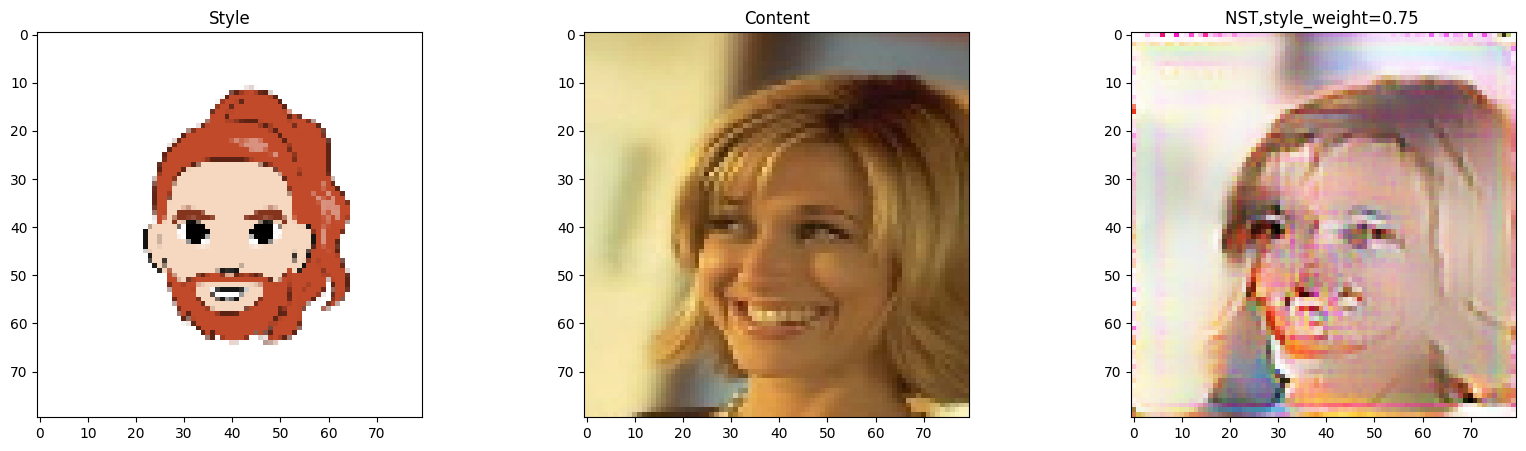

In [93]:
import matplotlib.pyplot as plt
# Encode the style and content image.
test_style_encoded = model.encoder(test_style)
test_content_encoded = model.encoder(test_content)
# Compute the AdaIN features.
test_t = ada_in(style=test_style_encoded, content=test_content_encoded)
test_reconstructed_image = model.decoder(test_t)
# Plot the Style, Content and the NST image.
# Plot the Style, Content and the NST image.
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax[0].imshow(tf.keras.utils.array_to_img(test_style[0]))
ax[0].set_title("Style")
ax[1].imshow(tf.keras.utils.array_to_img(test_content[0]))
ax[1].set_title("Content")
ax[2].imshow(
    tf.keras.utils.array_to_img(test_reconstructed_image[0])
)
ax[2].set_title(f"NST,style_weight={style_weight} ")
plt.show()
plt.close()

In [94]:
direccion='/kaggle/input/impressionist-classifier-data/training/training/VanGogh/205859.jpg'
test_style_2 = decode_and_resize(direccion)

In [95]:
test_style_2 = tf.reshape(test_style_2, (1, 80, 80, 3))

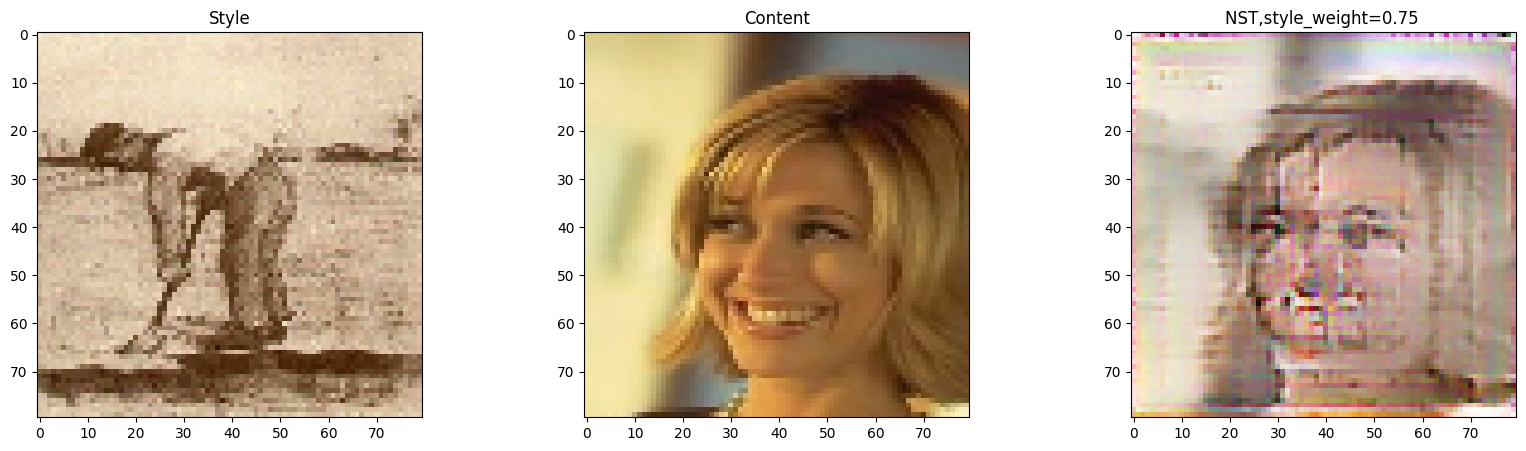

In [97]:
import matplotlib.pyplot as plt
# Encode the style and content image.
test_style_encoded = model.encoder(test_style_2)
test_content_encoded = model.encoder(test_content)
# Compute the AdaIN features.
test_t = ada_in(style=test_style_encoded, content=test_content_encoded)
test_reconstructed_image = model.decoder(test_t)
# Plot the Style, Content and the NST image.
# Plot the Style, Content and the NST image.
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax[0].imshow(tf.keras.utils.array_to_img(test_style_2[0]))
ax[0].set_title("Style")
ax[1].imshow(tf.keras.utils.array_to_img(test_content[0]))
ax[1].set_title("Content")
ax[2].imshow(
    tf.keras.utils.array_to_img(test_reconstructed_image[0])
)
ax[2].set_title(f"NST,style_weight={style_weight} ")
plt.show()
plt.close()

Probemos el modelo con otros estilos